In [2]:
# get the boreholeNames
import os, fnmatch
from collections import OrderedDict

def getBoreholeName(fileDir):
    """
    :in fileDir: directory to the folder
    :out boreholeNames: boreholeNames in a list 
    
    """
    
    listOfFiles = os.listdir(fileDir)
    pattern = "*.mat"
    matFile = []
    for entry in listOfFiles:
        if fnmatch.fnmatch(entry, pattern):
            matFile.append(entry.split('_')[0])
# '624reshape.mat' was deleted that's why the index is [1:]     
# set to delete the duplicates(without), but results are not in order
    #boreholeNames = list(set(matFile[1:])) 
    boreholeNames = list(OrderedDict.fromkeys(matFile[1:]).keys())
    
    return boreholeNames

In [3]:
# load mat file
from scipy.io import loadmat
def loadMat(path2MatFile):   
    """
    :in path2MatFile: directory to the mat data "*/*.mat"
    :out data: matlab inversion results 
    
    """
    data = loadmat(path2MatFile)
    maxFit = data['maxFit']
    T2 = data['t2in']
    maxDist = data['maxDist']
    # dist.shape = (1,12)
    dist = data['dist']
    # stacking along rows shape(80,12)
    T2dist = np.hstack((dist[0][:]))
    
    depth = data['depth']
    # depth calibration with the well head
    depth -= depth[0]
    T2 = np.array(T2)
    return T2, depth, T2dist.T


In [4]:
# interpolate to make it convenient to plot
from scipy.interpolate import RectBivariateSpline as RBS
from scipy.interpolate import griddata
import numpy as np

# works well
def interpolation_RBS(T2, depth, T2dist):
    
    f = RBS(depth, T2, T2dist, kx = 1, ky =1) # kx, ky =1 is linear interpolation
    # load mat file
from scipy.io import loadmat
def loadMat(path2MatFile):   
    """
    :in path2MatFile: directory to the mat data "*/*.mat"
    :out data: matlab inversion results 
    
    """
    data = loadmat(path2MatFile)
    maxFit = data['maxFit']
    T2 = data['t2in']
    maxDist = data['maxDist']
    # dist.shape = (1,12)
    dist = data['dist']
    # stacking along rows shape(80,12)
    T2dist = np.hstack((dist[0][:]))
    
    depth = data['depth']
    # depth calibration with the well head
    depth -= depth[0]
    T2 = np.array(T2)
    return T2, depth, T2dist.T
    up_T2 = np.geomspace(np.min(T2), np.max(T2), 160)
    up_depth = np.linspace(np.min(depth), np.max(depth), 24)   
    
    zRBS = f(up_depth, up_T2)
    return up_T2, up_depth,zRBS

# works well
def interpolation_griddata(T2, depth, T2dist):  
  
    grid_T2, grid_depth = np.meshgrid(T2, depth)
    
    up_T2 = np.geomspace(np.min(T2), np.max(T2), 160)
    up_depth = np.linspace(np.min(depth), np.max(depth), 24)   
    
    Xg, Yg = np.meshgrid(up_T2, up_depth)  
    
    points = np.vstack([np.ravel(grid_T2, order ='F'), np.ravel(grid_depth, order ='F')]).T
    values = np.ravel(T2dist, order ='F')
    
    ZGD = griddata(points, values, (Xg, Yg), method = "linear")
    # np.ravel(grid_T2, order ='F') [0.0001, 0.00001....0.0001, 0.000015....10] (960,)
    # np.ravel(grid_depth, order ='F') [0.  , 0.25, 0.5 , 0.75, 1.  , 1.25, 1.5 , 1.75, 2.....] (960,)
    # Yg.T.shape (160, 24)
    # Xg.T.shape (160, 24)
    # ZGD.shape (160, 24)
    return up_T2, up_depth, ZGD   


In [5]:
#### 2-D surf plot 
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
   
def pltpcolormesh(xi, yi,zi):   
    """
    in: gridded data 
    out: 2d surf figure
    
    """   
    fig, ax = plt.subplots(figsize=(4,8))
    pbar = ax.pcolormesh(xi, yi, zi, shading='flat', cmap='RdBu_r')# coolwarm
    ax.set_xscale('log')
    #ax.set_ylim(0.5,2.75)
    ax.invert_yaxis()    
    
    ax.set_ylabel('Depth (m)',fontsize=14)
    ax.set_xlabel('$T_2$ (s)',fontsize=14)      
    
    fig.tight_layout()
    plt.colorbar(pbar)
    plt.show()      

D:/Woodland_NMR_Dart_Discus_June_Sep2016\WO55109_freq2_June.mat


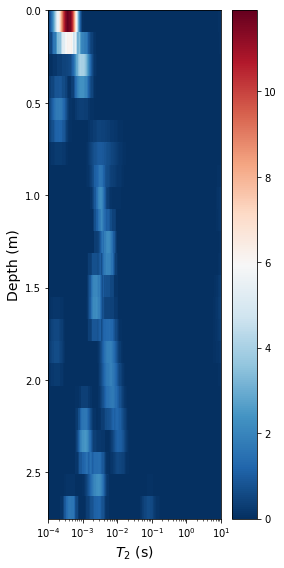

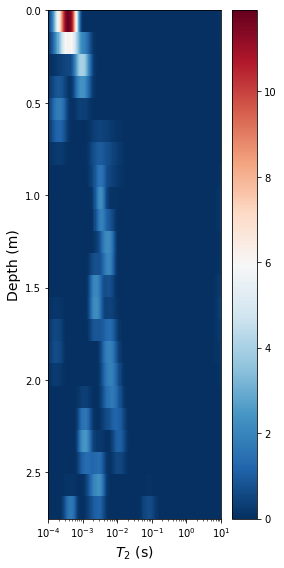

In [5]:
# main entrance 2-D T2-dist plotting

import numpy as np
import matplotlib.pyplot as plt
if __name__ =="__main__":    
    fileDir = 'D:/Woodland_NMR_Dart_Discus_June_Sep2016'
    # get names of all boreholes
    boreholeNames = getBoreholeName(fileDir)
    
    freqs = ['freq1', 'freq2']
    months = ['June','sep']    
    
    fileName = boreholeNames[15] + '_' + freqs[1] + '_' + months[0] +'.mat'    
    path2MatFile = os.path.join(fileDir, fileName)
    print(path2MatFile)
    # load mat file
    T2, depth, T2dist = loadMat(path2MatFile)  
    
    T2_gd, depth_gd,T2dist_gd = interpolation_griddata(T2, depth, T2dist)

    pltpcolormesh(T2_gd, depth_gd,T2dist_gd)
    
    T2_RBS, depth_RBS,T2dist_RBS = interpolation_RBS(T2, depth, T2dist)
    
    pltpcolormesh(T2_RBS, depth_RBS,T2dist_RBS)

In [6]:
# ridgeline plot on T2-dist --a simple one
import numpy as np
import matplotlib.pyplot as plt

def ridgeline(T2, T2dist, overlap=0, fill=True, labels=None):
    """
    Creates a standard ridgeline plot.
    T2: numpy array of T2 (size = 80 or 160 during inversion)
    data of T2-dist: numpy array with shape number of depth * number of T2
    
    overlap, overlap between distributions. 1 max overlap, 0 no overlap.
    
    fill, matplotlib color to fill the distributions.
        
    labels, values to place on the y axis to describe the distributions.
    """
    if overlap > 1 or overlap < 0:
        raise ValueError('overlap must be in [0 1]')
    x_T2 = np.geomspace(np.min(T2), np.max(T2), T2.size)

    ys = []
    len_T2dist = T2dist.shape[0]
    
    for i in range(len_T2dist-1,-1,-1):        
        y = i*(1.0-overlap)
        ys.append(y)
        if fill:
            plt.fill_between(x_T2, np.ones(T2.size)*y, T2dist[i,:] + y, zorder=len_T2dist-i+1, color=fill)
        plt.plot(x_T2, T2dist[i,:] + y, c ='k', zorder=len_T2dist-i+1)
        
    if labels.any():
        plt.yticks(ys, labels)

D:/Woodland_NMR_Dart_Discus_June_Sep2016\WO55109_freq2_June.mat
dimension of x:  80
dimension of y:  (12, 1)
dimension of z:  (12, 80)


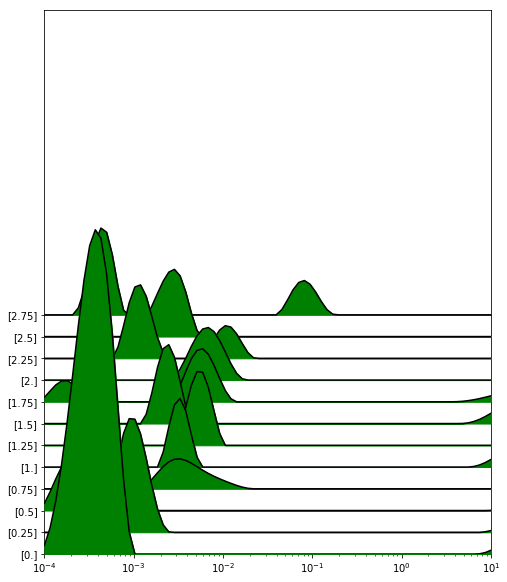

In [7]:
# main entrance to t2-dist stack ridegplotting

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

if __name__ =="__main__":    
    fileDir = 'D:/Woodland_NMR_Dart_Discus_June_Sep2016'
    # get names of all boreholes
    boreholeNames = getBoreholeName(fileDir)
    
    freqs = ['freq1', 'freq2']
    months = ['June','sep']    
    
    fileName = boreholeNames[15] + '_' + freqs[1] + '_' + months[0] +'.mat'    
    path2MatFile = os.path.join(fileDir, fileName)
    print(path2MatFile)
    # load mat file
    T2, depth, T2dist = loadMat(path2MatFile)  
    
    print("dimension of x: ", T2.size)
    print("dimension of y: ",depth.shape)
    print("dimension of z: ", T2dist.shape)   
    fig, ax = plt.subplots(figsize=(8,10))
    ridgeline(T2, T2dist, overlap=0.2, fill= 'g',labels= depth[::-1])
    ax.set_xscale('log')
    #plt.grid(zorder=0)
    plt.xlim(np.min(T2), np.max(T2))
    plt.ylim((0, 20))
       
    plt.show()

In [7]:
# reference to https://matplotlib.org/matplotblog/posts/create-ridgeplots-in-matplotlib/
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as grid_spec

def pltGridSpec(T2, T2dist, depth, fig):
    """
    Creates a standard ridgeline plot with gridspec.
    T2: numpy array of T2 (size = 80 or 160 during inversion)
    data of T2-dist: numpy array with shape number of depth * number of T2
    """
    
    depths = [x for x in np.unique(depth)]
    x_T2 = np.geomspace(np.min(T2), np.max(T2), T2.size)
    len_T2dist = T2dist.shape[0]
    
    gs = grid_spec.GridSpec(len_T2dist,1) 
    
    colors = ['#3300cc', '#660099', '#990066', '#ece2f0','#d0d1e6','#a6bddb','#67a9cf','#3690c0','#02818a','#016c59','#014636']

    ax = [ ]
    i = 1

    while i < len_T2dist:

        ax.append(fig.add_subplot(gs[i:i+1, 0]))

        ax[-1].semilogx(T2, T2dist[i,:], c='k', lw = 0.1)
        ax[-1].fill_between(x_T2, T2dist[i,:], alpha=1, color= 'g', where = T2dist[i,:]>0)

        ax[-1].set_ylim(0,5) #np.max(T2dist[i,:])
        ax[-1].set_xlim(1e-4, 10)

        ax[-1].set_yticklabels([])
        ax[-1].set_yticks([])
        ax[-1].set_ylabel('')
        # ax[-1].set_xscale('log')

        # make background transparent
        rect = ax[-1].patch
        rect.set_alpha(0)

        # xticks only for the bottom axis
        if i == len_T2dist-1:
            ax[-1].set_xlabel("$T_2 (s)$", fontsize= 14,fontweight="bold")
        else:
            ax[-1].set_xticklabels([])
            ax[-1].set_xticks([])
            ax[-1].set_xticks([], minor=True)
        # boxoff and now show lines    
        spines = ["top","right","left"]#"bottom"
        for s in spines:
            ax[-1].spines[s].set_visible(False)

        ax[-1].text(1e-4, 0, '{:3.2f}'.format(depths[i]), fontsize=12, ha="right") #rotation=45, fontweight="bold",

        i += 1

    gs.update(hspace= -0.3)
    return fig

D:/Woodland_NMR_Dart_Discus_June_Sep2016\WO07116_freq2_sep.mat


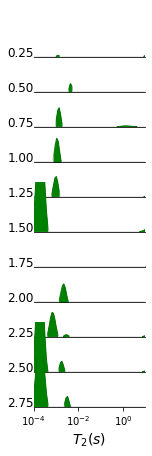

In [8]:
# main entrance to t2-dist stack joyplotting
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

if __name__ =="__main__":    
    fileDir = 'D:/Woodland_NMR_Dart_Discus_June_Sep2016'
    # get names of all boreholes
    boreholeNames = getBoreholeName(fileDir)
    
    freqs = ['freq1', 'freq2']
    months = ['June','sep']    
    
    fileName = boreholeNames[4] + '_' + freqs[1] + '_' + months[1] +'.mat'  
    path2MatFile = os.path.join(fileDir, fileName)
    print(path2MatFile)
    # load mat file
    T2, depth, T2dist = loadMat(path2MatFile)  
    fig = plt.figure(figsize=(2,8)) 
    Fig = pltGridSpec(T2, T2dist, depth, fig)
    plt.show()